In [8]:
import numpy as np
import pandas as pd
import random
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

from harp_resources import process, utils
from sleap import load_and_process as lp

In [22]:
def make_test_streams(session, csv = False, h5 = True):
    freq = '0.1ms'  # 0.1 milliseconds
    if session == 1:
        start_time = pd.Timestamp('1904-01-09 19:54:29.679')
        end_time = pd.Timestamp('1904-01-09 20:31:03.269')
        
        timestamps = pd.date_range(start=start_time, end=end_time, freq=freq)
        
        
        # Create sine wave 1 (1 Hz frequency)
        sine_wave1 = pd.Series(
            np.sin(3 * np.pi * 1.5 * (timestamps - timestamps[0]).total_seconds() / 60),
            index=timestamps)
        
        # Create sine wave 2 (0.5 Hz frequency)
        sine_wave2 = pd.Series(
            np.sin(1 * np.pi * 0.35 * (timestamps - timestamps[0]).total_seconds() / 60),
            index=timestamps)
        
        # Create square wave
        square_wave = pd.Series(
            (np.sign(np.sin(2 * np.pi * 0.5 * (timestamps - timestamps[0]).total_seconds() / 60)) > 0).astype(float),
            index=timestamps)
        
        # Create boolean stream
        boolean_values = np.random.choice(
            [True, False], 
            size=len(timestamps), 
            p=[0.98, 1-0.98]  # Probability of True and False
        )
        boolean_stream = pd.Series(boolean_values, index=timestamps)


    if session == 2:
        start_time = pd.Timestamp('1904-01-10 16:45:32.679')
        end_time = pd.Timestamp('1904-01-10 17:20:03.269')

        timestamps = pd.date_range(start=start_time, end=end_time, freq=freq)
        
        # Create sine wave 1 (1 Hz frequency)
        sine_wave1 = pd.Series(
            np.sin(2 * np.pi * 1 * (timestamps - timestamps[0]).total_seconds() / 60),
            index=timestamps)
        
        # Create sine wave 2 (0.5 Hz frequency)
        sine_wave2 = pd.Series(
            np.sin(3 * np.pi * 0.5 * (timestamps - timestamps[0]).total_seconds() / 60),
            index=timestamps)
        
        # Create square wave
        square_wave = pd.Series(
            (np.sign(np.sin(2 * np.pi * 1 * (timestamps - timestamps[0]).total_seconds() / 60)) > 0).astype(float),
            index=timestamps)
        
        # Create boolean stream
        boolean_values = np.random.choice(
            [True, False], 
            size=len(timestamps), 
            p=[0.96, 1-0.96])  # Probability of True and False
        boolean_stream = pd.Series(boolean_values, index=timestamps)

        
        

    # Sparse event stream
    event_stream = pd.Series(index=timestamps, dtype="object")
    event_indices = sorted(random.sample(range(len(timestamps)), 20))  # 20 random events
    event_values = ['No halt'] * 15 + [
    "LinearPlaybackMismatch block started",
    "LinearClosedloopMismatch block started",
    "Block timer elapsed",]
    random.shuffle(event_values)
    for idx, val in zip(event_indices, event_values):
        event_stream.iloc[idx] = val

    # Remove NaNs from the event stream to only keep event timepoints
    event_stream = event_stream.dropna()

    # Print the series to confirm their format
    print("Sine Wave 1:\n", sine_wave1)
    print("\nSine Wave 2:\n", sine_wave2)
    print("\nSquare Wave:\n", square_wave)
    print("\nBoolean Stream:\n", boolean_stream)
    print("\nEvent Stream:\n", event_stream)

    # Create a figure with subplots
    fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    fig.suptitle("Generated Streams", fontsize=16)
    
    # Plot sine_wave1
    axes[0].plot(sine_wave1.index, sine_wave1.values, label="Sine Wave 1 (1 Hz)", color="blue")
    axes[0].set_ylabel("Sine Wave 1")
    
    # Plot sine_wave2
    axes[1].plot(sine_wave2.index, sine_wave2.values, label="Sine Wave 2 (0.5 Hz)", color="green")
    axes[1].set_ylabel("Sine Wave 2")
    
    # Plot square_wave
    axes[2].plot(square_wave.index, square_wave.values, label="Square Wave", color="orange")
    axes[2].set_ylabel("Square Wave")
    
    # Plot boolean_stream as shaded regions
    axes[3].fill_between(boolean_stream.index, 0, 1, where=boolean_stream.values, 
                         facecolor="gray", alpha=0.3, label="Boolean True Regions")
    axes[3].set_ylabel("Boolean Stream")

    # Plot event_stream
    axes[4].scatter(event_stream.index, [0] * len(event_stream), color="red", label="Event Stream")
    axes[4].set_ylabel("Event Stream")
    
    # Common x-label
    axes[-1].set_xlabel("Time")
    
    # Tidy layout
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
    plt.show()

    #Check percentage of True values, halts
    percent_true = (len(boolean_stream==True)*100)/len(boolean_stream)

    # Count the total number of rows
    total_count = boolean_stream.count()
    
    # Count the number of True and False values
    true_count = boolean_stream.sum()  # Sums True values (True = 1, False = 0)
    false_count = total_count - true_count
    
    # Calculate percentages
    true_percentage = (true_count / total_count) * 100
    false_percentage = (false_count / total_count) * 100
    
    # Print results
    print(f"Percentage of True values: {true_percentage:.2f}%")
    print(f"Percentage of False values: {false_percentage:.2f}%")

    # Define the file paths, must exist already
    if session == 1:
        data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_070824/Test_streams_B0M0')
        output_folder = data_path / "ExperimentEvents"
        output_csv_path = output_folder / 'ExperimentEvents_1904-01-02T22-00-00.csv'
    if session == 2:
        data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0')
        output_folder = data_path / "ExperimentEvents"
        output_csv_path = output_folder / 'ExperimentEvents_1904-01-03T08-00-00.csv'
    
    output_folder.mkdir(parents=True, exist_ok=True)  # Ensure the folder exists
    
    
    # Convert timestamps to seconds using the provided function
    time_in_seconds = process.convert_datetime_to_seconds(event_stream.index)
    
    # Create the DataFrame for saving
    event_stream_df = pd.DataFrame({
        "Seconds": time_in_seconds,
        "Value": event_stream.values
    })
    
 
    event_stream_df.to_csv(output_csv_path, index=False)
    print(f"Event stream saved to {output_csv_path}")


    #Prep to h5 saving
    data = {'H1': {'OpticalTrackingRead0X(46)': sine_wave1, 'OpticalTrackingRead0Y(46)': square_wave},
            'H2':{}, 
            'Photometry': {'CH1-470': sine_wave2},
            'ONIX': {'Photodiode': boolean_stream}}
    
    
    streams_to_save_pattern = {'H1': ['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)'], 
                               'H2': ['Encoder(38)'], 'Photometry': ['CH1-410', 'CH1-470', 'CH1-560'], 'ONIX': ['Photodiode']}
    
    if h5:
        process.save_streams_as_h5(data_path, data, streams_to_save_pattern)
        print(f'\nH5 was attempted saved to {data_path}\n')

    
    # Flatten the dictionary into a DataFrame
    columns = []
    data_frames = []

    for subsystem, streams in data.items():
        for stream_name, series in streams.items():
            # Create column names as "Subsystem: Stream Name"
            column_name = stream_name
            columns.append(column_name)
            print(column_name)
            data_frames.append(series)
    
    combined_df = pd.concat(data_frames, axis=1)
    combined_df.columns = columns
    
    # Add the Seconds column
    combined_df['Seconds'] = process.convert_datetime_to_seconds(combined_df.index)
    
    
    if csv:
        output_path = f"Original_Fake_data_session{session}.csv"
        combined_df.to_csv(output_path, index=False)
    
        print(f"Data saved to {output_path}")

    return combined_df
            


Sine Wave 1:
 1904-01-09 19:54:29.679000    0.000000
1904-01-09 19:54:29.679100    0.000024
1904-01-09 19:54:29.679200    0.000047
1904-01-09 19:54:29.679300    0.000071
1904-01-09 19:54:29.679400    0.000094
                                ...   
1904-01-09 20:31:03.268600    0.998178
1904-01-09 20:31:03.268700    0.998176
1904-01-09 20:31:03.268800    0.998175
1904-01-09 20:31:03.268900    0.998173
1904-01-09 20:31:03.269000    0.998172
Freq: 100us, Length: 21935901, dtype: float64

Sine Wave 2:
 1904-01-09 19:54:29.679000    0.000000
1904-01-09 19:54:29.679100    0.000002
1904-01-09 19:54:29.679200    0.000004
1904-01-09 19:54:29.679300    0.000005
1904-01-09 19:54:29.679400    0.000007
                                ...   
1904-01-09 20:31:03.268600    0.598058
1904-01-09 20:31:03.268700    0.598056
1904-01-09 20:31:03.268800    0.598055
1904-01-09 20:31:03.268900    0.598053
1904-01-09 20:31:03.269000    0.598052
Freq: 100us, Length: 21935901, dtype: float64

Square Wave:
 1904-0

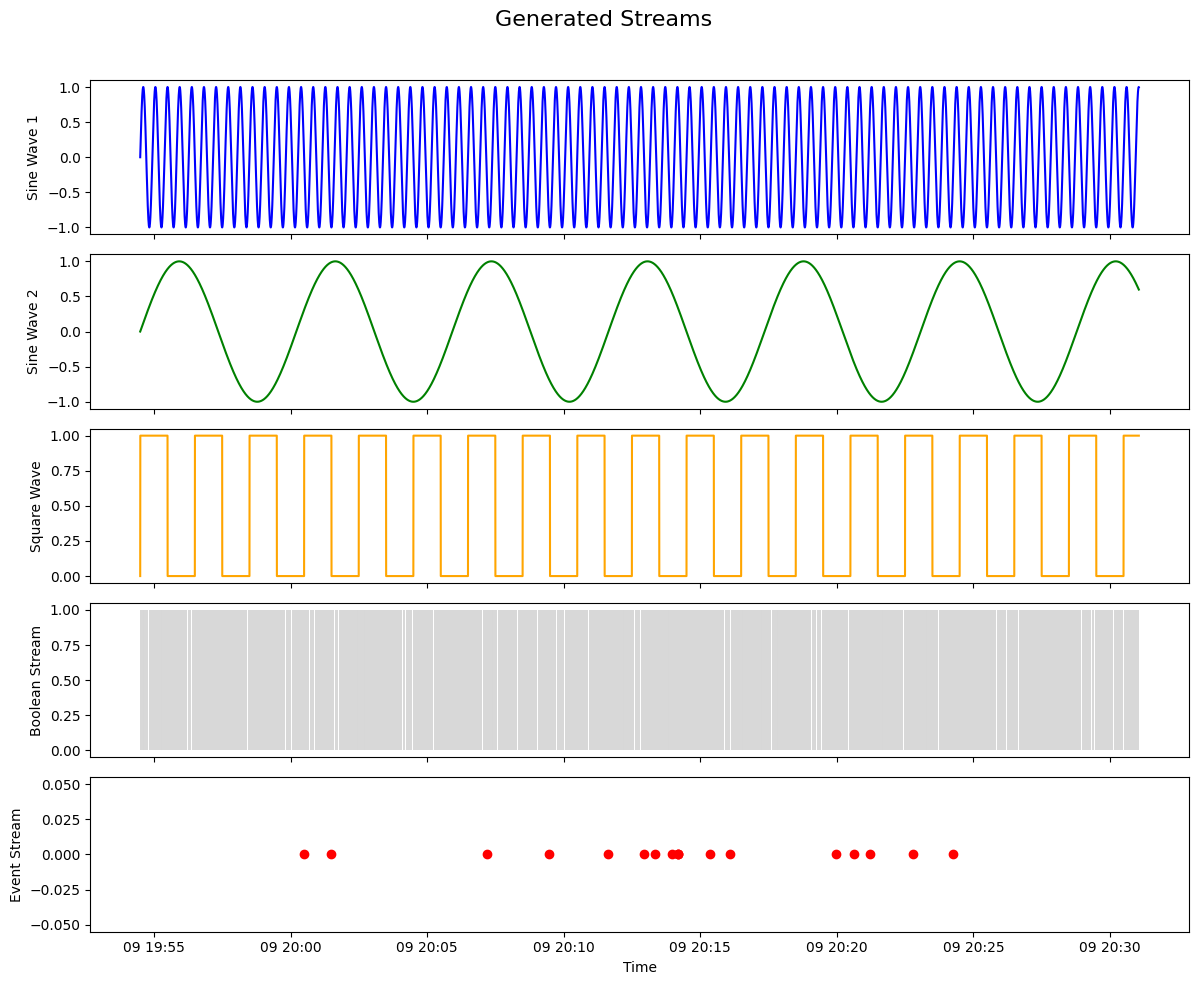

Percentage of True values: 98.00%
Percentage of False values: 2.00%
Event stream saved to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_070824/Test_streams_B0M0/ExperimentEvents/ExperimentEvents_1904-01-02T22-00-00.csv
Encoder(38) was included in "streams_to_save_pattern", but cannot be found inside of H2 source of resampled streams.
CH1-410 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
CH1-560 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
Data saved as H5 file in 3.61 seconds to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_070824/Test_streams_B0M0/resampled_streams_Test_streams_B0M0.h5.

H5 was attempted saved to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_070824/Test_streams_B0M0

OpticalTrackingRead0X(46)
OpticalTrackingRead0Y(46)
CH1-470
Photodiode
Sine Wave 1:
 1904-01-10 16:45:32.679000    0.000000
1904-01-10 16:

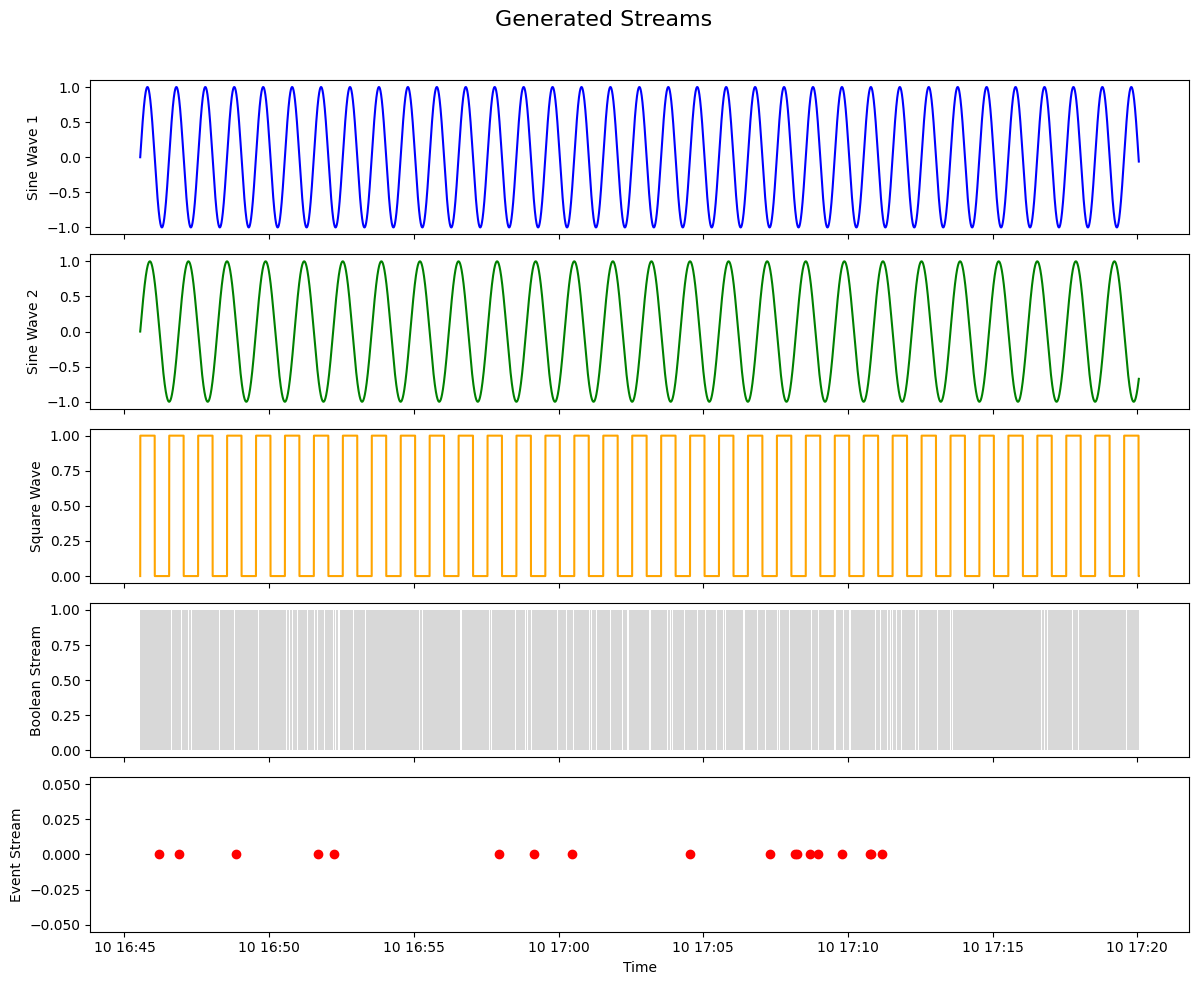

Percentage of True values: 95.99%
Percentage of False values: 4.01%
Event stream saved to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0/ExperimentEvents/ExperimentEvents_1904-01-03T08-00-00.csv
Encoder(38) was included in "streams_to_save_pattern", but cannot be found inside of H2 source of resampled streams.
CH1-410 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
CH1-560 was included in "streams_to_save_pattern", but cannot be found inside of Photometry source of resampled streams.
Data saved as H5 file in 3.23 seconds to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0/resampled_streams_Test_streams_B0M0.h5.

H5 was attempted saved to /Volumes/RanczLab/20240730_Mismatch_Experiment/Fake_data_080824/Test_streams_B0M0

OpticalTrackingRead0X(46)
OpticalTrackingRead0Y(46)
CH1-470
Photodiode


In [23]:
df_1 = make_test_streams(1)
df_2 = make_test_streams(2)